In [1]:
import os
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import re

from helper_scripts.cleaning_scripts import *

In [2]:
interim_data_path = os.path.join('..', 'data', 'interim', 'DOB_job_application.csv')
df = pd.read_csv(interim_data_path, low_memory=False)
df.head()

,Job_Num,Doc_Num,Borough,Job_Type,Job_Status,Building_Type,Community_Board,Cluster,Landmarked,Adult_Estab,Loft_Board,City_Owned,Little_e,PC_Filed,eFiling_Filed,Plumbing,Mechanical,Boiler,Fuel_Burning,Fuel_Storage,Standpipe,Sprinkler,Fire_Alarm,Equipment,Fire_Suppression,Curb_Cut,Other,Other_Description,Pre_Filing_Date,Paid,Fully_Paid,Assigned,Approved,Fully_Permitted,Initial_Cost,Total_Est_Fee,Fee_Status,Existing_Zoning_Sqft,Proposed_Zoning_Sqft,Horizontal_Enlrgmt,Vertical_Enlrgmt,Enlargement_SQ_Footage,Street_Frontage,ExistingNo_of_Stories,Proposed_No_of_Stories,Existing_Height,Proposed_Height,Existing_Dwelling_Units,Proposed_Dwelling_Units,Existing_Occupancy,Proposed_Occupancy,Site_Fill,Zoning_Dist1,Zoning_Dist2,Zoning_Dist3,Special_District_1,Special_District_2,Owner_Type,NonProfit,Job_Description,TOTAL_CONSTRUCTION_FLOOR_AREA,WITHDRAWAL_FLAG,SIGNOFF_DATE,SPECIAL_ACTION_STATUS,SPECIAL_ACTION_DATE,BUILDING_CLASS,JOB_NO_GOOD_COUNT,GIS_LATITUDE,GIS_LONGITUDE,GIS_NTA_NAME
0,420291794,1,QUEENS,A3,X,OTHERS,412,N,N,N,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,ANTENNA,11/29/2010,11/29/2010,12/29/2010,12/30/2010,01/10/2011,01/25/2011,2000.0,100.0,STANDARD,0,0,NaN,NaN,0,0,2,2,24,24,NaN,NaN,COM,COM,NaN,M1-2,NaN,NaN,NaN,IBZ,PARTNERSHIP,N,INSTALLING 2'X2' TELECOMMUNICATIONS EQUIPMENT ...,0,0,08/02/2011,N,NaN,E1,0,40.708932,-73.776983,Jamaica
1,420291801,1,QUEENS,A2,X,1-2-3 FAMILY,410,N,N,N,N,NaN,N,NaN,Y,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11/29/2010,11/29/2010,11/29/2010,11/30/2010,01/21/2011,01/21/2011,15000.0,151.5,STANDARD,0,0,NaN,NaN,0,0,3,3,35,35,2,2,R-3,R-3,NOT APPLICABLE,R4,NaN,NaN,NaN,NaN,CORPORATION,N,INSTALLATION OF WET SPRINKLER SYSTEM OFF DOMES...,0,0,10/31/2011,N,NaN,B2,0,40.669071,-73.838928,Ozone Park
2,340644128,1,BROOKLYN,A2,X,1-2-3 FAMILY,306,N,N,N,N,NaN,N,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,SOLAR TAX,11/02/2018,11/02/2018,11/02/2018,11/05/2018,11/05/2018,11/08/2018,44726.0,234.0,STANDARD,0,0,NaN,NaN,0,0,2,2,28,28,2,2,R-3,R-3,NOT APPLICABLE,R6B,NaN,NaN,NaN,NaN,INDIVIDUAL,N,INSTALL SOLAR PV SYSTEM ON THE EXISTING ROOFTO...,0,0,03/18/2019,N,NaN,B1,0,40.679058,-73.981126,Park Slope-Gowanus
3,421685439,1,QUEENS,NB,P,1-2-3 FAMILY,411,N,N,N,N,NaN,N,NaN,Y,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,GEN. CONSTR.,11/02/2018,11/02/2018,11/02/2018,11/05/2018,04/09/2019,NaN,0.0,243.0,STANDARD,0,2700,NaN,NaN,0,0,0,2,0,28,NaN,2,NaN,R-3,USE UNDER 300 CU.YD,R3A,NaN,NaN,NaN,NaN,PARTNERSHIP,N,HEREWITH FILED FOR A NEW DETACHED 2-STORY 2-FA...,4050,0,NaN,N,NaN,A0,0,40.765658,-73.787240,Bayside-Bayside Hills
4,421677974,2,QUEENS,A2,R,OTHERS,401,N,N,NaN,N,NaN,NaN,NaN,Y,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09/12/2018,09/12/2018,09/12/2018,NaN,NaN,NaN,105000.0,1275.6,STANDARD,0,0,NaN,NaN,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CORPORATION,N,MECHANICAL AND PLUMBING WORK AS SHOWN ON PLANS,0,0,NaN,N,NaN,E9,0,40.755622,-73.925003,Astoria


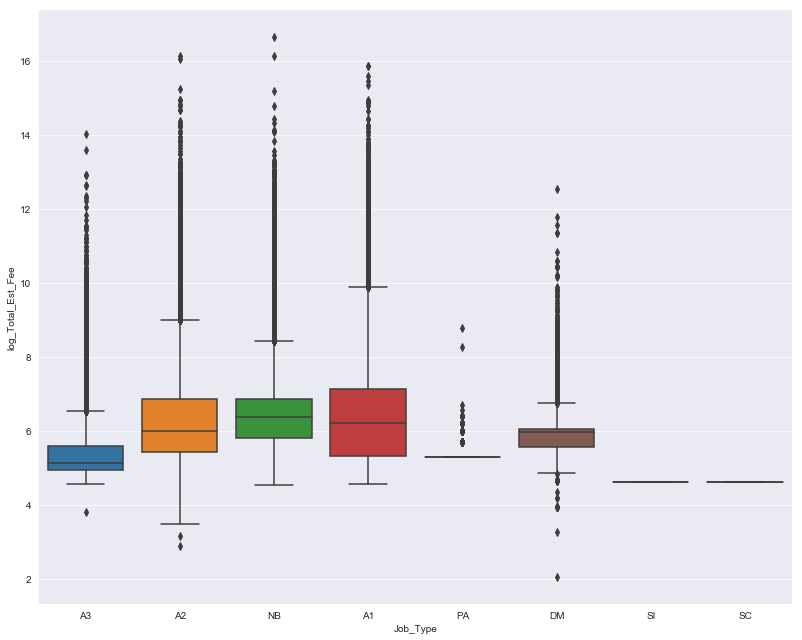

In [5]:
#sbn.distplot(np.log(df[df['Total_Est_Fee']>0]['Total_Est_Fee']))
df_plot = df[df['Total_Est_Fee']>0][['Job_Type','Total_Est_Fee']]
df_plot['log_Total_Est_Fee'] = np.log(df_plot['Total_Est_Fee'])

sns.catplot(x="Job_Type", y="log_Total_Est_Fee", kind="box", data=df_plot, height=9, aspect=1.25)

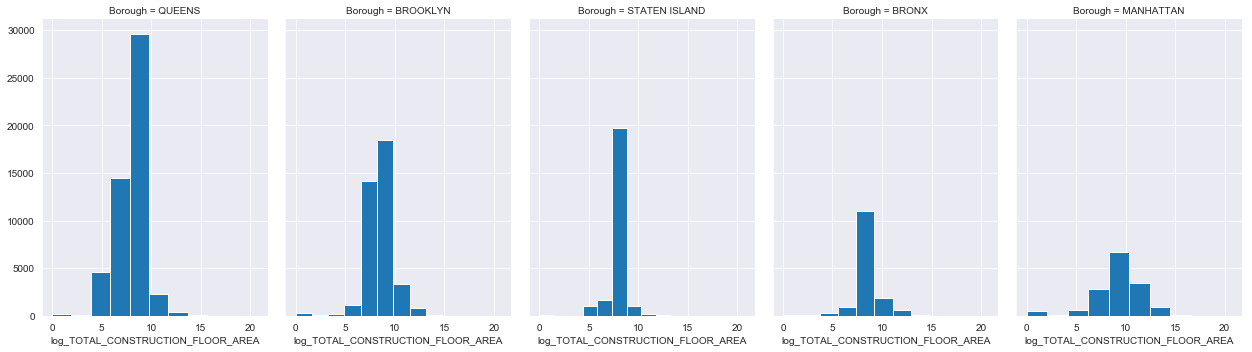

In [15]:
df_plot = df[df['TOTAL_CONSTRUCTION_FLOOR_AREA']>0][['Borough','TOTAL_CONSTRUCTION_FLOOR_AREA']]
df_plot['log_TOTAL_CONSTRUCTION_FLOOR_AREA'] = np.log(df_plot['TOTAL_CONSTRUCTION_FLOOR_AREA'])

g = sns.FacetGrid(df_plot, col="Borough", height=5, aspect=0.7)
g = g.map(plt.hist, "log_TOTAL_CONSTRUCTION_FLOOR_AREA")

In [135]:
df_plot = df[(~df['Fully_Permitted'].isna()) & (~df['Pre_Filing_Date'].isna())].copy()
df_plot[['Pre_Filing_Date', 'Fully_Permitted']] = df_plot[['Pre_Filing_Date', 'Fully_Permitted']].apply(get_date)
df_plot = df_plot[~((df_plot['Fully_Permitted']==datetime(1900,1,1).date()) | (df_plot['Fully_Permitted'] >= (datetime.now()+ timedelta(days=365)).date()))]
df_plot = df_plot[~((df_plot['Pre_Filing_Date']==datetime(1900,1,1).date()) | (df_plot['Pre_Filing_Date'] >= (datetime.now()+ timedelta(days=365)).date()))]
df_plot['Filing_to_Permit_days'] = (df_plot['Fully_Permitted'] - df_plot['Pre_Filing_Date']).dt.days.map(float)
df_plot = df_plot[df_plot['Filing_to_Permit_days'] > 0]

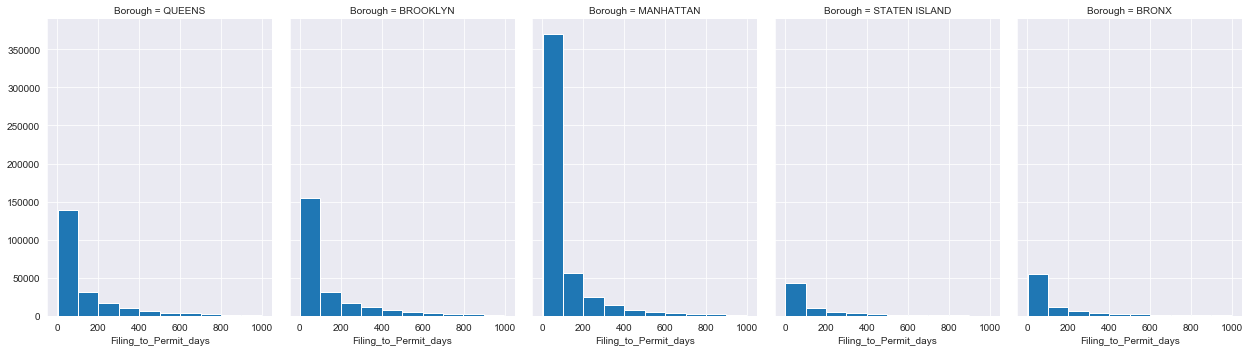

In [112]:
g = sns.FacetGrid(df_plot[df_plot['Filing_to_Permit_days']<1000], col="Borough", height=5, aspect=0.7)
g = g.map(plt.hist, "Filing_to_Permit_days")

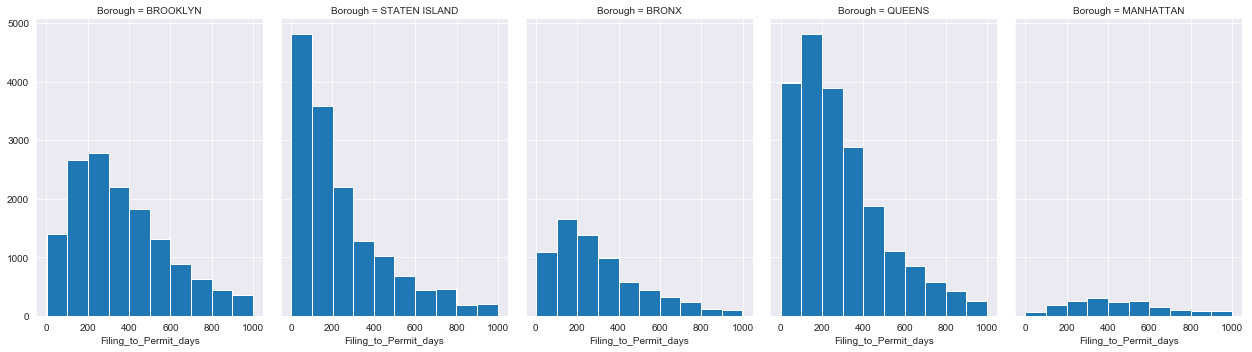

In [113]:
g = sns.FacetGrid(df_plot[(df_plot['Job_Type']=='NB') & (df_plot['Filing_to_Permit_days']<1000)], col="Borough", height=5, aspect=0.7)
g = g.map(plt.hist, "Filing_to_Permit_days")

C:\Users\shooh_000\Miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\shooh_000\Miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


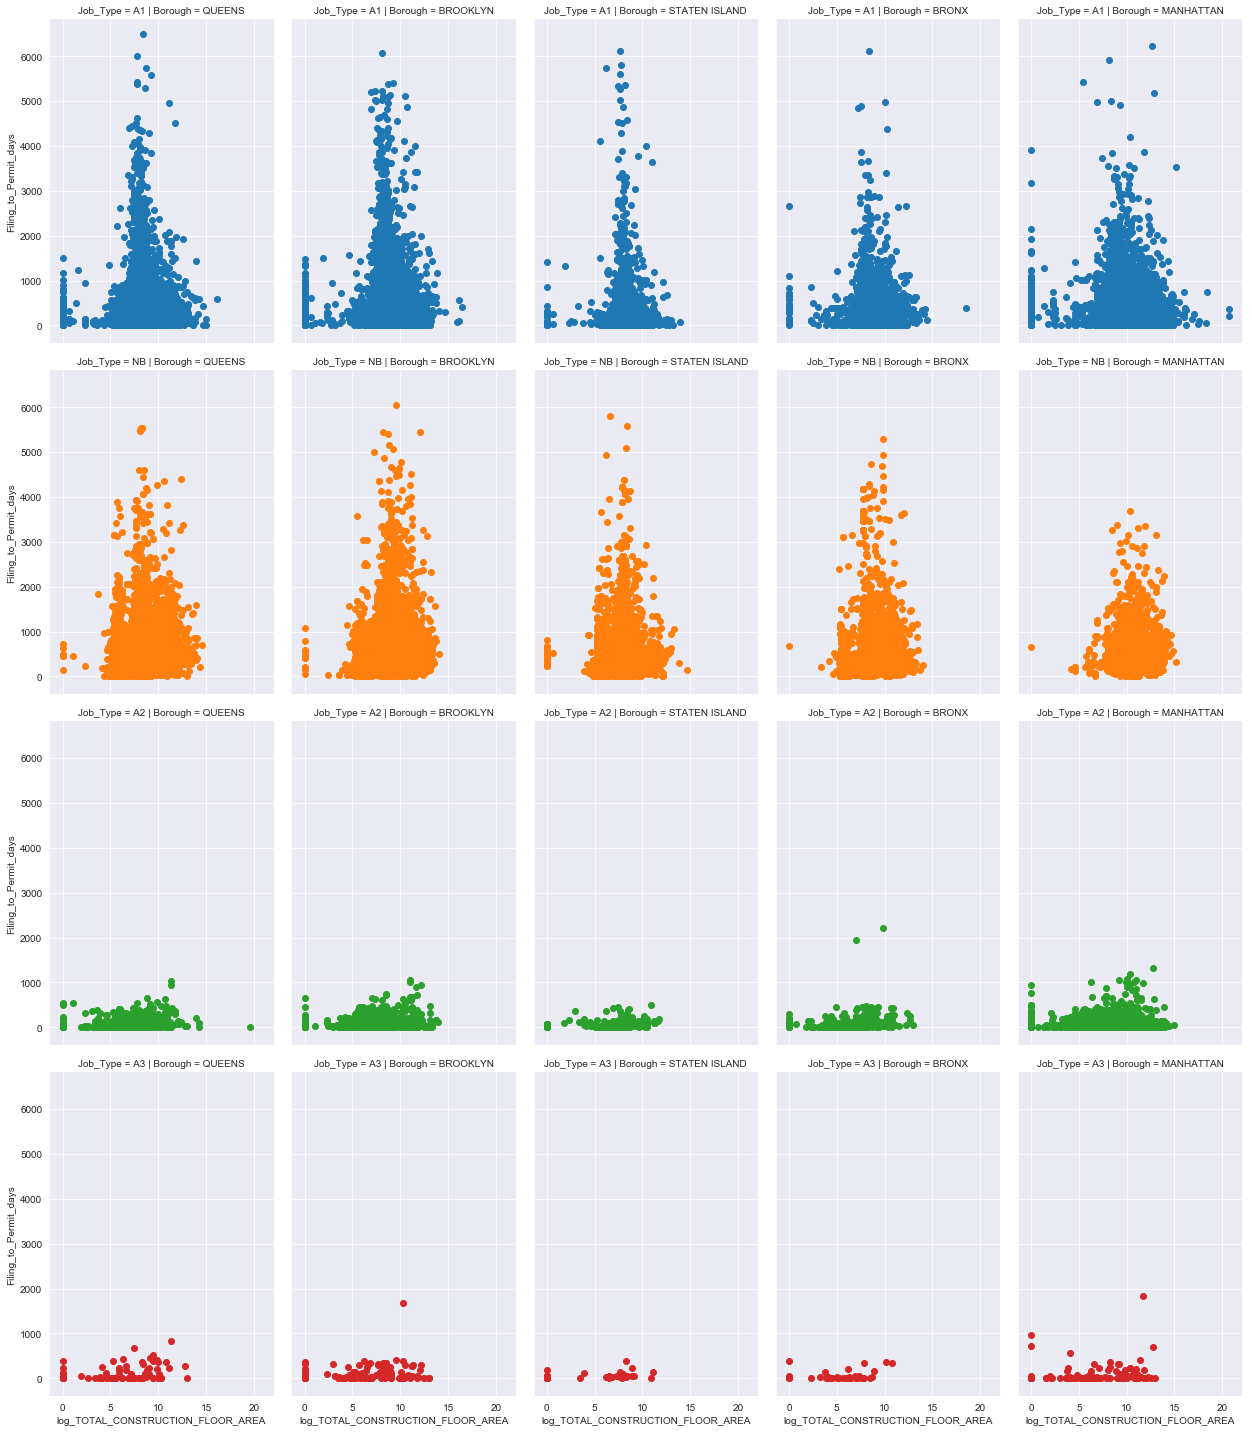

In [136]:
df_plot_scatter = df_plot[(df_plot['TOTAL_CONSTRUCTION_FLOOR_AREA'] > 0) & (df_plot['Job_Type']!='DM')]
df_plot_scatter['log_TOTAL_CONSTRUCTION_FLOOR_AREA'] = np.log(df_plot['TOTAL_CONSTRUCTION_FLOOR_AREA'])
g = sns.FacetGrid(df_plot_scatter, col="Borough",row='Job_Type',hue='Job_Type',height=5, aspect=0.7)
g = g.map(plt.scatter,"log_TOTAL_CONSTRUCTION_FLOOR_AREA", "Filing_to_Permit_days")
#sns.scatterplot(y="log_TOTAL_CONSTRUCTION_FLOOR_AREA", x="Filing_to_Permit_days",data=df_plot)
#plt.scatter(x='log_TOTAL_CONSTRUCTION_FLOOR_AREA', y='Filing_to_Permit_days',data=df_plot)